In [ ]:
#default_exp textbox_dataset_isri_greek

# ISRI GREEK (BAD DATASET, not all bboxes are selected)

> [image] -> [segmentation maps]

download dataset with cmd: `git clone https://ancientgreekocr.org/grcground.git`  
dir structure: 
`
./data/isri_greek/
    | bsb...1.png
    | bsb...1.txt
    | bsb...1.uzn
    ...
`

In [ ]:
#export
from ocr.core import save_dict, read_dict, plot
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pathlib import PosixPath

In [ ]:
#export
class isri_greek_config:
    MAIN_DIR = PosixPath('../data/isri_greek/')
    PROCESSED_IMG_DIR = PosixPath('../data/textbox/isri_greek/')
    FILE_DIR = PosixPath('../data/textbox/isri_greekbbox.pickle')

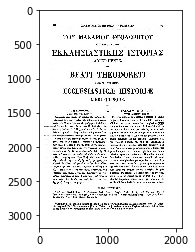

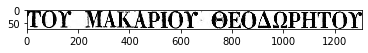

In [ ]:
im = cv2.imread(str(isri_greek_config.MAIN_DIR/'bsb10800809_0881.png'))
plot(im)
l,t,w,h,cat = [352, 361, 1306, 72, 'Text/Greek']
plot(im[t:t+h , l:l+w])

In [ ]:
im = cv2.imread(str(isri_greek_config.MAIN_DIR/'bsb10800809_0881.png'))
im2 = cv2.imread(str(isri_greek_config.MAIN_DIR/'njp.32101077772802_0881.png'))
print(im.shape, im2.shape)

(3190, 2085, 3) (3118, 1987, 3)


In [ ]:
im = cv2.imread(str(isri_greek_config.MAIN_DIR/'bsb10800809_0881.png'))
im2 = cv2.imread(str(isri_greek_config.MAIN_DIR/'njp.32101077772802_0881.png'))
im = tensor(im.astype(int)).to('cuda')
im2 = tensor(im2.astype(int)).to('cuda')
min_error = 1e12
err = 0
coords = []
for y in progress_bar(range(im.shape[0]-im2.shape[0])):
    for x in range(im.shape[1]-im2.shape[1]):
        tmp = torch.zeros_like(im).to('cuda') + 255
        tmp[ y:y+im2.shape[0] , x:x+im2.shape[1] ] = im2
        error = (tmp - im).abs().sum()
        if error < min_error:
            min_error = error
            coords = [x,y]
print(min_error, coords)
plot(tmp)

KeyboardInterrupt: 

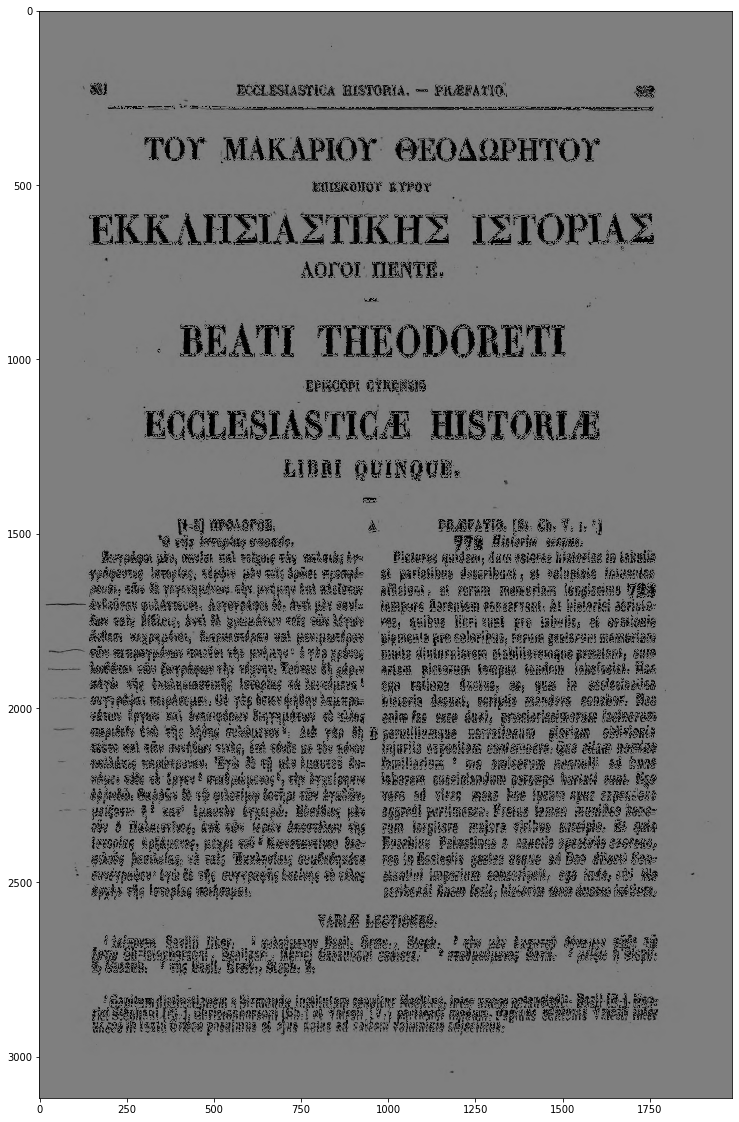

In [ ]:
im = cv2.imread(str(isri_greek_config.MAIN_DIR/'bsb10800809_0881.png'))
im2 = cv2.imread(str(isri_greek_config.MAIN_DIR/'njp.32101077772802_0881.png'))
x,y = 50, 0
plot(((im[ y:y+im2.shape[0] , x:x+im2.shape[1] ]+im2)/2).astype(np.uint8), figsize=(20,20))

In [ ]:
ids = set()
for fp in isri_greek_config.MAIN_DIR.iterdir():
        fn = str(fp).split('/')[-1]
        im_id = fn[-8:-4]
        if fn[-3:] == 'png':
            ids.add(im_id)
im_ids = list(ids)
len(im_ids)

384

In [ ]:
def find_images_with_id(iid):
    im_paths = {}
    for fp in isri_greek_config.MAIN_DIR.iterdir():
        fn = str(fp).split('/')[-1]
        im_id = fn[-8:-4]
        if fn[-3:] == 'png' and im_id == iid:
            mode = fn.split('.')[0]
            if mode.startswith('bsb'): mode = 'bsb'
            im_paths[mode] = fp
    return im_paths

In [ ]:
read_lines = lambda fp: open(fp).readlines()
def read_uzn(uzn_path):
    bboxes = []
    for line in read_lines(uzn_path):
        try: l,t,w,h,cat = [w for w in line.split(' ') if w != '']
        except: continue # there are some `  ` (double space) lines
        l,t,w,h = map(int, [l,t,w,h])
        b, r = t+h, l+w
        l, t = max(l, 0), max(t, 0)
        r, b = min(r, im.shape[1]), min(b, im.shape[0])
        bboxes.append((t, l, b, r))
    return bboxes

In [ ]:
filtered_ids = []
for iid in im_ids:
    im_paths = find_images_with_id(iid)
    try:
        assert len(im_paths) == 5
        filtered_ids.append(iid)
    except: pass
len(filtered_ids)

362

In [ ]:
isri_greek_data = {}
device = 'cuda'
# max_h, max_w = 0, 0
for iid in progress_bar(filtered_ids):
    im_paths = find_images_with_id(iid)
    single_example = defaultdict(lambda:{})
    for k in ['coo','nnc1','njp','hvd','bsb']:
        im_path = str(im_paths[k])
        uzn_path = im_path[:-3] + 'uzn'
        bboxes = read_uzn(uzn_path)
        single_example[k]['im_path'] = im_path
        single_example[k]['bboxes'] = tensor(bboxes).float().to(device)
#     for k in single_example:
#         im_path = single_example[k]['im_path']
#         h,w,c = cv2.imread(im_path).shape
#         if h > max_h: max_h = h
#         if w > max_w: max_w = w
    isri_greek_data[iid] = single_example

In [ ]:
max_h, max_w = (6486, 4218)

In [ ]:
isri_greek_data['1348']['coo']['bboxes'][0] / 6486

tensor([0.0669, 0.5697, 0.0771, 0.3215], device='cuda:0')

### Fix this piece of shit

In [ ]:
from ocr.bbox_east_inference import bboxes_on_image

In [ ]:
# manually found
bad_idxes = set([9,14,17,21,35,42,55,59,62,75,79,84,90,96,107,117,120,128,133,153,155,167,173,178,200,201,230,240,260,266,269,273,294,304,307,309,316,318,319,326,341,344,351,354])

In [ ]:
pad = 50
# i, win = 0, 10
# for j,iid in enumerate(list(isri_greek_data.keys())[i*win:(i+1)*win]):
#     j += i*win
total, total_bbox = 0, 0
filename2bbs = {}
for j,iid in enumerate(progress_bar(list(isri_greek_data.keys()))):
    if j in bad_idxes: continue
    total += 1
    for k in ['bsb']: # or 'njp'
        im_path = isri_greek_data[iid][k]['im_path']
        img = cv2.imread(im_path)
        bboxes = isri_greek_data[iid][k]['bboxes'].long()
        # crop width
        median, _ = bboxes.median(0)
        median[1] -= pad
        median[3] += pad
        # crop height
        only_in_crop = (bboxes[:,1] > median[1]) * (bboxes[:,3] < median[3])
        maxes, _ = bboxes[only_in_crop].max(0)
        mins, _ = bboxes[only_in_crop].min(0)
        mins[0] -= pad
        maxes[2] += pad
        # resize original bboxes w/ img
        bboxes[:,1] -= median[1]
        bboxes[:,3] -= median[1]
        bboxes[:,0] -= mins[0]
        bboxes[:,2] -= mins[0]
        img = img[ mins[0]:maxes[2] , median[1]:median[3] ]
        bboxes = bboxes[only_in_crop]
        bboxes = [list(map(int, (t,l,b,r))) for t,l,b,r in bboxes]
        fn = str(im_path).split('/')[-1]
        cv2.imwrite(str(isri_greek_config.PROCESSED_IMG_DIR/fn), img)
        filename2bbs[fn] = (bboxes, ['line'] * len(bboxes))
        total_bbox += len(bboxes)
print('total:', total)
print('total bboxes:', total_bbox)
save_dict(dict(filename2bbs), isri_greek_config.FILE_DIR)

total: 318
total bboxes: 16238


In [ ]:
#export
def get_filename2bboxes_dict():
    return read_dict(isri_greek_config.FILE_DIR)

In [ ]:
#export
def create_df():
    fn2bboxes = get_filename2bboxes_dict()
    data = []
    for fn in fn2bboxes.keys():
        img_path = str(isri_greek_config.PROCESSED_IMG_DIR/fn)
        data.append((img_path, False, 'isri_greek'))
    return pd.DataFrame(data, columns=['image_path', 'valid', 'dataset'])

In [ ]:
create_df()

,image_path,valid,dataset
0,../data/isri_greek/bsb10800809_1348.png,True,isri_greek
1,../data/isri_greek/bsb10800809_1497.png,True,isri_greek
2,../data/isri_greek/bsb10800809_0933.png,True,isri_greek
3,../data/isri_greek/bsb10800809_1288.png,True,isri_greek
4,../data/isri_greek/bsb10800809_1057.png,True,isri_greek
...,...,...,...
313,../data/isri_greek/bsb10800809_1313.png,True,isri_greek
314,../data/isri_greek/bsb10800809_1021.png,True,isri_greek
315,../data/isri_greek/bsb10800809_1248.png,True,isri_greek
316,../data/isri_greek/bsb10800809_1364.png,True,isri_greek
